In [8]:
import torch
import argparse
import random
import numpy as np
import pandas as pd
from src.graph_func import graph_construction
from src.utils_func import mk_dir, adata_preprocess, load_ST_file, res_search_fixed_clus, plot_clustering
from src.training import conST_training

import anndata
from sklearn import metrics
import matplotlib.pyplot as plt
import scanpy as sc
import os
import warnings
warnings.filterwarnings('ignore')

In [9]:
parser = argparse.ArgumentParser()
parser.add_argument('--k', type=int, default=10, help='parameter k in spatial graph')
parser.add_argument('--knn_distanceType', type=str, default='euclidean',
                    help='graph distance type: euclidean/cosine/correlation')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--cell_feat_dim', type=int, default=300, help='Dim of PCA')
parser.add_argument('--feat_hidden1', type=int, default=100, help='Dim of DNN hidden 1-layer.')
parser.add_argument('--feat_hidden2', type=int, default=20, help='Dim of DNN hidden 2-layer.')
parser.add_argument('--gcn_hidden1', type=int, default=32, help='Dim of GCN hidden 1-layer.')
parser.add_argument('--gcn_hidden2', type=int, default=8, help='Dim of GCN hidden 2-layer.')
parser.add_argument('--p_drop', type=float, default=0.2, help='Dropout rate.')
parser.add_argument('--use_img', type=bool, default=False, help='Use histology images.')
parser.add_argument('--img_w', type=float, default=0.1, help='Weight of image features.')
parser.add_argument('--use_pretrained', type=bool, default=False, help='Use pretrained weights.')
parser.add_argument('--using_mask', type=bool, default=False, help='Using mask for multi-dataset.')
parser.add_argument('--feat_w', type=float, default=10, help='Weight of DNN loss.')
parser.add_argument('--gcn_w', type=float, default=0.1, help='Weight of GCN loss.')
parser.add_argument('--dec_kl_w', type=float, default=10, help='Weight of DEC loss.')
parser.add_argument('--gcn_lr', type=float, default=0.01, help='Initial GNN learning rate.')
parser.add_argument('--gcn_decay', type=float, default=0.01, help='Initial decay rate.')
parser.add_argument('--dec_cluster_n', type=int, default=10, help='DEC cluster number.')
parser.add_argument('--dec_interval', type=int, default=20, help='DEC interval nnumber.')
parser.add_argument('--dec_tol', type=float, default=0.00, help='DEC tol.')

parser.add_argument('--seed', type=int, default=0, help='random seed')
parser.add_argument('--beta', type=float, default=100, help='beta value for l2c')
parser.add_argument('--cont_l2l', type=float, default=0.3, help='Weight of local contrastive learning loss.')
parser.add_argument('--cont_l2c', type=float, default= 0.1, help='Weight of context contrastive learning loss.')
parser.add_argument('--cont_l2g', type=float, default= 0.1, help='Weight of global contrastive learning loss.')

parser.add_argument('--edge_drop_p1', type=float, default=0.1, help='drop rate of adjacent matrix of the first view')
parser.add_argument('--edge_drop_p2', type=float, default=0.1, help='drop rate of adjacent matrix of the second view')
parser.add_argument('--node_drop_p1', type=float, default=0.2, help='drop rate of node features of the first view')
parser.add_argument('--node_drop_p2', type=float, default=0.3, help='drop rate of node features of the second view')

# ______________ Eval clustering Setting ______________
parser.add_argument('--eval_resolution', type=int, default=1, help='Eval cluster number.')
parser.add_argument('--eval_graph_n', type=int, default=20, help='Eval graph kN tol.') 

params =  parser.parse_args(args=['--k', '20', '--knn_distanceType', 'euclidean', '--epochs', '200'])

np.random.seed(params.seed)
torch.manual_seed(params.seed)
torch.cuda.manual_seed(params.seed)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using device: ' + device)
params.device = device

Using device: cuda:0


In [10]:

# adata_h5 = sc.read_h5ad('/home/workspace2/zhaofangyuan/data_h5ad/without_groundtruth/Visium_demon/V1_Mouse_Brain_Sagittal_Posterior.h5ad')
# adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
# graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
# np.save('./input/V1_Mouse_Brain_Sagittal_Posterior/adatax.npy', adata_X)
# np.save('./input/V1_Mouse_Brain_Sagittal_Posterior/graphdict.npy', graph_dict, allow_pickle = True)


In [11]:
# set seed before every run
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch(params.seed)

In [12]:
data_name = 'V1_Mouse_Brain_Sagittal_Posterior'
save_root = './output/spatialLIBD/'
data_root = '../spatialLIBD'

params.save_path = mk_dir(f'{save_root}/{data_name}/conST')

adata_h5 = sc.read_h5ad('/home/workspace2/zhaofangyuan/data_h5ad/without_groundtruth/Visium_demon/V1_Mouse_Brain_Sagittal_Posterior.h5ad')

adata_X = np.load('./input/V1_Mouse_Brain_Sagittal_Posterior/adatax.npy')
graph_dict = np.load('./input/V1_Mouse_Brain_Sagittal_Posterior/graphdict.npy',  allow_pickle = True).item()
params.cell_num = adata_h5.shape[0]

In [13]:

def get_refine(sample_id, pred, dis, shape="hexagon"):
    refined_pred=[]
    pred=pd.DataFrame({"pred": pred}, index=sample_id)
    dis_df=pd.DataFrame(dis, index=sample_id, columns=sample_id)
    if shape=="hexagon":
        num_nbs=6 
    elif shape=="square":
        num_nbs=4
    else:
        print("Shape not recongized, shape='hexagon' for Visium data, 'square' for ST data.")
    for i in range(len(sample_id)):
        index=sample_id[i]
        dis_tmp=dis_df.loc[index, :].sort_values(ascending=False)
        nbs=dis_tmp[0:num_nbs+1]
        nbs_pred=pred.loc[nbs.index, "pred"]
        self_pred=pred.loc[index, "pred"]
        v_c=nbs_pred.value_counts()
        if (v_c.loc[self_pred]<num_nbs/2) and (np.max(v_c)>num_nbs/2):
            refined_pred.append(v_c.idxmax())
        else:           
            refined_pred.append(self_pred)
    return refined_pred

Pretraining stage:  |                | 5 / 200 | Left time: 0.08 mins| Loss: 210.9540

0


Pretraining stage:  |############### | 199 / 200 | Left time: 0.00 mins| Loss: 186.3204etraining stage:  |                | 10 / 200 | Left time: 0.10 mins| Loss: 206.3872Pretraining stage:  |#               | 13 / 200 | Left time: 0.08 mins| Loss: 205.5900Pretraining stage:  |#               | 14 / 200 | Left time: 0.07 mins| Loss: 205.1101Pretraining stage:  |#               | 15 / 200 | Left time: 0.07 mins| Loss: 204.6621Pretraining stage:  |##              | 35 / 200 | Left time: 0.06 mins| Loss: 200.3510Pretraining stage:  |###             | 40 / 200 | Left time: 0.06 mins| Loss: 199.6808Pretraining stage:  |###             | 41 / 200 | Left time: 0.06 mins| Loss: 198.2166Pretraining stage:  |#######         | 92 / 200 | Left time: 0.04 mins| Loss: 193.7380Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 186.8590
Major training stage:  |################| 200 / 200 | Loss: 3.4907


0.10999999999999997


Pretraining stage:  |                | 1 / 200 | Left time: 0.10 mins| Loss: 221.7555

1


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 186.2018retraining stage:  |##              | 26 / 200 | Left time: 0.07 mins| Loss: 202.3066Pretraining stage:  |####            | 57 / 200 | Left time: 0.06 mins| Loss: 197.2870Pretraining stage:  |####            | 60 / 200 | Left time: 0.06 mins| Loss: 196.4156Pretraining stage:  |####            | 61 / 200 | Left time: 0.06 mins| Loss: 197.3473Pretraining stage:  |######          | 84 / 200 | Left time: 0.05 mins| Loss: 195.4592Pretraining stage:  |######          | 85 / 200 | Left time: 0.05 mins| Loss: 193.3925Pretraining stage:  |########        | 100 / 200 | Left time: 0.06 mins| Loss: 193.4631Pretraining stage:  |########        | 102 / 200 | Left time: 0.04 mins| Loss: 192.0676Pretraining stage:  |#########       | 113 / 200 | Left time: 0.04 mins| Loss: 192.3582Pretraining stage:  |#########       | 114 / 200 | Left time: 0.03 mins| Loss: 192.2965
Major training stage:  |################| 200 / 2

0.24999999999999997


Pretraining stage:  |                | 4 / 200 | Left time: 0.08 mins| Loss: 212.2668

2


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 185.2462retraining stage:  |#               | 24 / 200 | Left time: 0.07 mins| Loss: 202.2659Pretraining stage:  |##              | 27 / 200 | Left time: 0.07 mins| Loss: 201.8323Pretraining stage:  |##              | 32 / 200 | Left time: 0.07 mins| Loss: 201.3680Pretraining stage:  |####            | 53 / 200 | Left time: 0.06 mins| Loss: 197.9134Pretraining stage:  |####            | 54 / 200 | Left time: 0.06 mins| Loss: 198.0155Pretraining stage:  |#####           | 64 / 200 | Left time: 0.06 mins| Loss: 197.1389Pretraining stage:  |#####           | 68 / 200 | Left time: 0.07 mins| Loss: 196.8734Pretraining stage:  |##########      | 125 / 200 | Left time: 0.03 mins| Loss: 190.2648Pretraining stage:  |#############   | 171 / 200 | Left time: 0.01 mins| Loss: 189.1643Pretraining stage:  |##############  | 183 / 200 | Left time: 0.01 mins| Loss: 188.3634
Major training stage:  |################| 200 / 20

0.20999999999999996


Pretraining stage:  |                | 4 / 200 | Left time: 0.10 mins| Loss: 212.0240

3


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 189.1956retraining stage:  |##              | 33 / 200 | Left time: 0.06 mins| Loss: 201.1298Pretraining stage:  |##              | 36 / 200 | Left time: 0.06 mins| Loss: 200.8087Pretraining stage:  |#####           | 74 / 200 | Left time: 0.05 mins| Loss: 195.6257Pretraining stage:  |######          | 86 / 200 | Left time: 0.05 mins| Loss: 194.0663Pretraining stage:  |######          | 87 / 200 | Left time: 0.04 mins| Loss: 194.1056Pretraining stage:  |#######         | 92 / 200 | Left time: 0.08 mins| Loss: 193.9199Pretraining stage:  |########        | 107 / 200 | Left time: 0.04 mins| Loss: 193.7818Pretraining stage:  |########        | 112 / 200 | Left time: 0.06 mins| Loss: 190.5744Pretraining stage:  |##########      | 130 / 200 | Left time: 0.03 mins| Loss: 191.4023Pretraining stage:  |###########     | 141 / 200 | Left time: 0.03 mins| Loss: 190.8023Pretraining stage:  |#############   | 167 / 200 |

0.4099999999999999


Pretraining stage:  |                | 3 / 200 | Left time: 0.10 mins| Loss: 214.1426

4


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 187.2119retraining stage:  |                | 12 / 200 | Left time: 0.13 mins| Loss: 205.2980Pretraining stage:  |##              | 25 / 200 | Left time: 0.09 mins| Loss: 202.8629Pretraining stage:  |#####           | 74 / 200 | Left time: 0.12 mins| Loss: 197.0452Pretraining stage:  |############### | 192 / 200 | Left time: 0.00 mins| Loss: 186.0794
Major training stage:  |################| 200 / 200 | Loss: 3.3916


0.35


Pretraining stage:  |                | 9 / 200 | Left time: 0.06 mins| Loss: 207.4537

5


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 189.1519retraining stage:  |###             | 41 / 200 | Left time: 0.05 mins| Loss: 199.9518
Major training stage:  |################| 200 / 200 | Loss: 3.4004


0.38999999999999996


Pretraining stage:  |                | 5 / 200 | Left time: 0.08 mins| Loss: 211.3291

6


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 187.5607retraining stage:  |#               | 19 / 200 | Left time: 0.18 mins| Loss: 203.7885Pretraining stage:  |##              | 28 / 200 | Left time: 0.10 mins| Loss: 201.3185Pretraining stage:  |###             | 39 / 200 | Left time: 0.06 mins| Loss: 199.0483Pretraining stage:  |######          | 82 / 200 | Left time: 0.06 mins| Loss: 194.6091Pretraining stage:  |######          | 84 / 200 | Left time: 0.05 mins| Loss: 193.7421Pretraining stage:  |###########     | 148 / 200 | Left time: 0.02 mins| Loss: 188.1363Pretraining stage:  |############    | 160 / 200 | Left time: 0.02 mins| Loss: 188.1911
Major training stage:  |################| 200 / 200 | Loss: 3.4987


0.44999999999999996


Pretraining stage:  |                | 4 / 200 | Left time: 0.08 mins| Loss: 212.4724

7


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 186.4942retraining stage:  |##              | 29 / 200 | Left time: 0.07 mins| Loss: 202.2706Pretraining stage:  |##              | 35 / 200 | Left time: 0.06 mins| Loss: 201.2463Pretraining stage:  |##              | 37 / 200 | Left time: 0.06 mins| Loss: 200.3388Pretraining stage:  |###             | 49 / 200 | Left time: 0.05 mins| Loss: 199.2845Pretraining stage:  |#####           | 65 / 200 | Left time: 0.05 mins| Loss: 196.5317Pretraining stage:  |#########       | 114 / 200 | Left time: 0.04 mins| Loss: 192.1462Pretraining stage:  |#########       | 115 / 200 | Left time: 0.03 mins| Loss: 192.0330
Major training stage:  |################| 200 / 200 | Loss: 3.4721


0.5299999999999999


Pretraining stage:  |                | 4 / 200 | Left time: 0.08 mins| Loss: 212.2662

8


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 185.9818retraining stage:  |#               | 13 / 200 | Left time: 0.07 mins| Loss: 205.5263Pretraining stage:  |#               | 14 / 200 | Left time: 0.07 mins| Loss: 205.2150Pretraining stage:  |#####           | 71 / 200 | Left time: 0.05 mins| Loss: 195.6717
Major training stage:  |################| 200 / 200 | Loss: 3.3677


0.59


Pretraining stage:  |                | 4 / 200 | Left time: 0.11 mins| Loss: 211.8451

9


Pretraining stage:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 188.9956retraining stage:  |                | 11 / 200 | Left time: 0.09 mins| Loss: 206.2842Pretraining stage:  |#               | 19 / 200 | Left time: 0.07 mins| Loss: 202.9778Pretraining stage:  |#####           | 66 / 200 | Left time: 0.05 mins| Loss: 196.0909Pretraining stage:  |###########     | 139 / 200 | Left time: 0.02 mins| Loss: 190.1324Pretraining stage:  |###########     | 140 / 200 | Left time: 0.02 mins| Loss: 188.6900Pretraining stage:  |#############   | 171 / 200 | Left time: 0.01 mins| Loss: 189.5040
Major training stage:  |################| 200 / 200 | Loss: 3.3826


0.7899999999999999


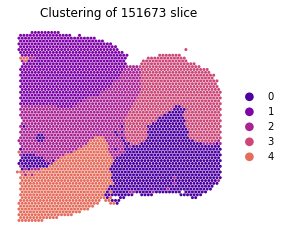

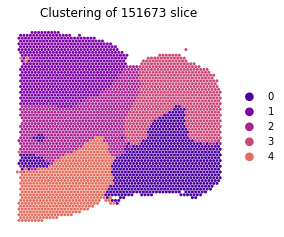

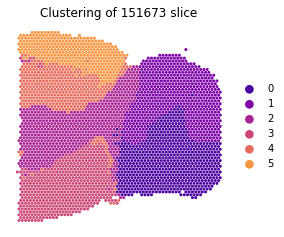

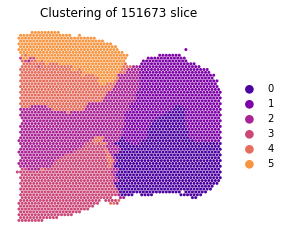

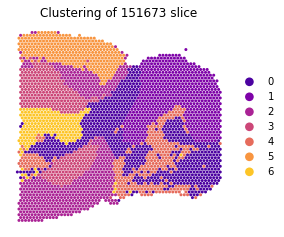

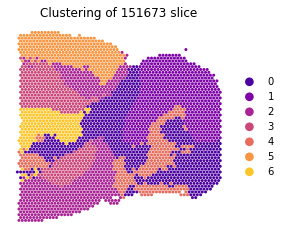

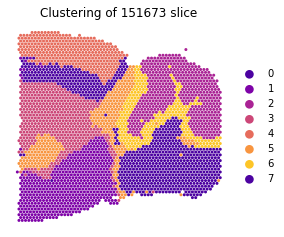

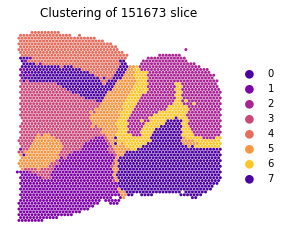

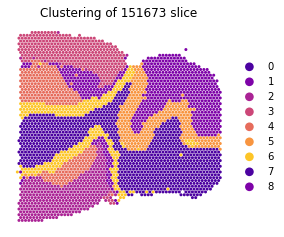

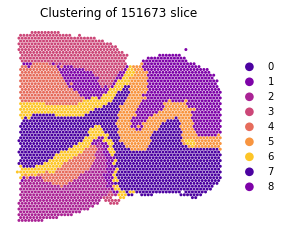

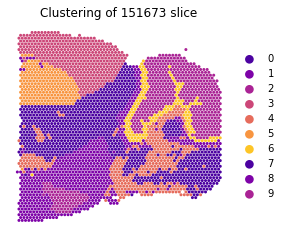

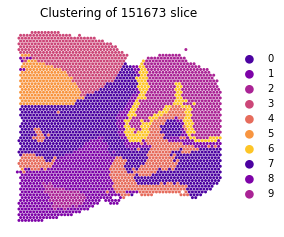

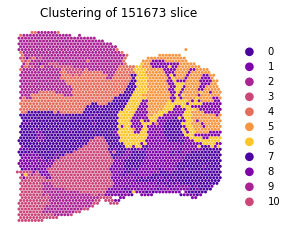

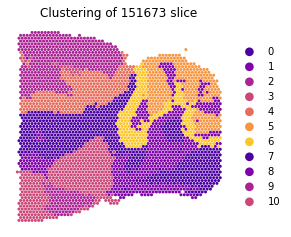

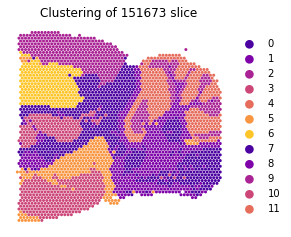

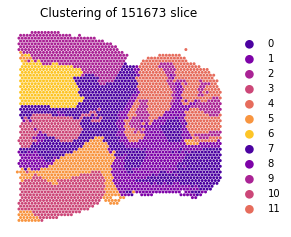

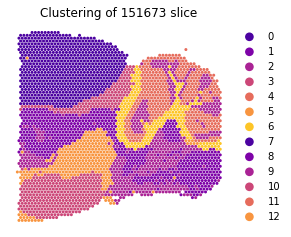

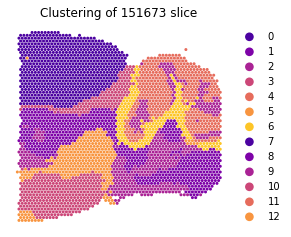

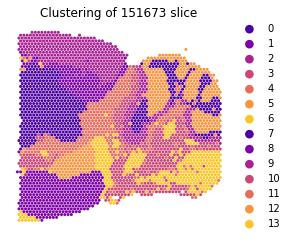

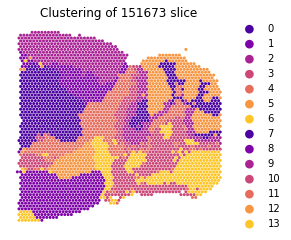

In [14]:

for j in range(10):
    print(j)
    n_clusters_list = [5,6,7,8,9,10,11,12,13,14]
    if params.use_img:
        img_transformed = np.load('./MAE-pytorch/extracted_feature.npy')
        img_transformed = (img_transformed - img_transformed.mean()) / img_transformed.std() * adata_X.std() + adata_X.mean()
        conST_net = conST_training(adata_X, graph_dict, params, n_clusters_list[j], img_transformed)
    else:
        conST_net = conST_training(adata_X, graph_dict, params, n_clusters_list[j])
    if params.use_pretrained:
        conST_net.load_model('conST_151674.pth')
    else:
        conST_net.pretraining()
        conST_net.major_training()

    conST_embedding = conST_net.get_embedding()

    np.save(f'{params.save_path}/conST_result.npy', conST_embedding)
    # clustering
    adata_conST = anndata.AnnData(conST_embedding)
    adata_conST.uns['spatial'] = adata_h5.uns['spatial']
    adata_conST.obsm['spatial'] = adata_h5.obsm['spatial']

    sc.pp.neighbors(adata_conST, n_neighbors=params.eval_graph_n)

    eval_resolution = res_search_fixed_clus(adata_conST, n_clusters_list[j])
    print(eval_resolution)
    cluster_key = "conST_leiden"
    sc.tl.leiden(adata_conST, key_added=cluster_key, resolution=eval_resolution)

    # plotting
    savepath = f'{params.save_path}/conST_leiden_plot_{j+1}.jpg'
    plot_clustering(adata_conST, cluster_key, savepath = savepath)

   
    adata_h5.obs['conST_{}'.format(j+1)] = adata_conST.obs[cluster_key]


    #refined
    index = np.arange(start=0, stop=adata_X.shape[0]).tolist()
    index = [str(x) for x in index]
    
    dis = graph_dict['adj_norm'].to_dense().numpy() + np.eye(graph_dict['adj_norm'].shape[0])
    refine = get_refine(sample_id = index, pred = adata_conST.obs['leiden'].tolist(), dis=dis)
    adata_conST.obs['refine'] = refine

    cluster_key = 'refine'
    savepath = f'{params.save_path}/conST_leiden_plot_refined_{j+1}.jpg'
    plot_clustering(adata_conST, cluster_key, savepath = savepath)

    adata_h5.obs['conST_refined_{}'.format(j+1)] = adata_conST.obs['refine']



adata_h5.write(f'{save_root}/V1_Mouse_Brain_Sagittal_Posterior/conST_V1_Mouse_Brain_Sagittal_Posterior(resolution).h5ad')

In [15]:
adata_h5

# df_meta = pd.read_csv(f'{data_root}/{data_name}/metadata.tsv', sep='\t')
# df_meta['conST_refine'] = adata_conST.obs['refine'].tolist()
# df_meta.to_csv(f'{params.save_path}/metadata.tsv', sep='\t', index=False)
# df_meta = df_meta[~pd.isnull(df_meta['layer_guess'])]
# ARI = metrics.adjusted_rand_score(df_meta['layer_guess'], df_meta['conST_refine'])
# print('===== Project: {} refined ARI score: {:.3f}'.format(data_name, ARI))

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'conST_1', 'conST_refined_1', 'conST_2', 'conST_refined_2', 'conST_3', 'conST_refined_3', 'conST_4', 'conST_refined_4', 'conST_5', 'conST_refined_5', 'conST_6', 'conST_refined_6', 'conST_7', 'conST_refined_7', 'conST_8', 'conST_refined_8', 'conST_9', 'conST_refined_9', 'conST_10', 'conST_refined_10'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

# 